# HCAS R notebook 02: projection pursuit regression

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 11 May 2016 (updated 20 May 2016)

**Note**: this notebook can also be viewed at https://github.com/eric542/hcas

## Summary

This notebook documents how the projection pursuit regression (PPR) approach can be applied to the task of environmental space modelling. This approach is described in detail in the document _'HCAS Activity 3a(1): Environmental Space Modelling -- Review / Research Document (Methods Document)'_.

The PPR technique is a multiple multivariate regression approach where the response (RS) variable $\mathbf{y}$ is modelled as a sum of $k$ non-linearly transformed linear combinations of the predictor (ENV) variables $\mathbf{x}$:

$$ \mathbb{E}( \mathbf{y} | \mathbf{x} ) = \bar{\mathbf{y}} + \sum_{k=1}^{K} \boldsymbol{\alpha}_k \cdot g_k ( \boldsymbol{\beta}_k^T \mathbf{x} ) $$

The terms $g_k(\cdot)$ are called _ridge functions_, while the coefficients of the vector $\boldsymbol{\beta}_k$ multiplying the ENV predictors $\mathbf{x}$ will be denoted as _term loadings_ in the following.

This notebook demonstrates how the PPR model can be fitted to the HCAS dataset of RS and ENV variables.

## Miscellaneous

Some preliminary `R` functions and definitions.

In [1]:
# function for plotting a colorbar in plots:
cbar = function(cmin,cmax,color_pal,ytxt="") {
    orig_mar = par("mar"); cbar_mar = c(orig_mar[1]+1,0,orig_mar[3]+1,3.7)
    par(mar=cbar_mar)
    tmp = seq(cmin,cmax,len=100)
    colsurf = matrix(c(tmp,tmp), nrow=2, byrow=TRUE)
    image(c(1,2), tmp, colsurf, col=color_pal, xlim=c(1,2), ylim=c(cmin,cmax), yaxt="n", xaxt="n", xlab="", ylab="")
    box(); axis(4); mtext(side=4, line=2.2, ytxt)
    par(mar=orig_mar)   # reset original parameters for other plots
}

In [2]:
# This allows to change the size of the figures in the notebook
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
suppressWarnings( library(gplots, warn=FALSE) )   # for hist2d()
cmap = c("#FFFFFF",topo.colors(250))
n_bins = 100
base_path = "//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/"

## Loading and pre-processing the HCAS variables

The HCAS variables can be loaded from file. We will also pre-process them as per the previous notebook in this series.

In [4]:
# Load HCAS variables:
print( load(paste(base_path,"HCAS_vars.Rdata",sep='')) )

[1] "site_latlon"             "site_env_vars"          
[3] "site_GDMenv_vars"        "site_RSorig_vars"       
[5] "site_RSpca_vars"         "site_indx_NonZeroPCA"   
[7] "pind_data_NonZeroPCA"    "TH_dist_data_NonZeroPCA"


In [5]:
# HCAS v1.0 scaling of RS space, using only PCA1 to PCA9:
site_RSpca_vars = site_RSpca_vars[,1:9] / 4

There are over 425,000 sites in the HCAS dataset, which leads to a significant computational burden. While the full dataset can be, and has been processed offline (along the lines of what is presented below), we will here use a subset of sites for illustration purposes in this notebook. And because we are ultimately interested in calculating distances for a number of _pairs_ of sites, we will be subsetting the pairs rather than the sites themselves (so as to ensure we've selected specific sites that are ultimately used to calculate distances).

The pairing information is contained in the variable `pind_data_NonZeroPCA` ('valid' pairs only, i.e. excluding those affected by the PCA issue discussed in the previous notebook), with a total of 986,549 pairs of sites, whose indices are stored in a 2D matrix:

In [6]:
t( pind_data_NonZeroPCA[1000:1010,] )   # examples of paired site indices for 10 pairs

762,763,764,765,766,767,768,769,770,771,772
147034,147524,147083,146683,1085,332517,816,147737,147338,147470,1363


Let's subset the available site pairs:

In [7]:
n_pairs = dim(pind_data_NonZeroPCA)[1]
p_subs_indx = seq(1, n_pairs, by=250)   # indices of pairs subset 
tmp = pind_data_NonZeroPCA[p_subs_indx,]
subs_indx = sort( unique( as.vector( tmp )))   # sites subset: only select sites once
site_env_vars = site_env_vars[subs_indx,]
site_RSpca_vars = site_RSpca_vars[subs_indx,]

n_sites = length(subs_indx)
n_pairs = length(p_subs_indx)
cat(paste("Resulting nr of sites is:", n_sites))
cat(paste("\nResulting nr of pairs is:", n_pairs))

Resulting nr of sites is: 7382
Resulting nr of pairs is: 3947

We will also use scaled (standardised) predictor variables:

In [8]:
site_env_vars_scld = scale(site_env_vars)

## Projection pursuit regression

The PPR approach is available within `R` as the function `ppr`:
```
    ppr(x, y, weights = rep(1, n),
        ww = rep(1, q), nterms, max.terms = nterms, optlevel = 2,
        sm.method = c("supsmu", "spline", "gcvspline"),
        bass = 0, span = 0, df = 5, gcvpen = 1, ...)
```
The main variables of interest are:

* `x`: numeric matrix of explanatory variables. Rows represent observations, and columns represent variables. 
* `y`: numeric matrix of response variables. Rows represent observations, and columns represent variables
* `nterms`: number of terms to include in the final model.
* `max.terms`: maximum number of terms to choose from when building the model.
* `sm.method`: the method used for smoothing the ridge functions. The default is to use Friedman's super smoother `supsmu`. The alternatives are to use the smoothing spline code underlying `smooth.spline`, either with a specified (equivalent) degrees of freedom for each ridge functions, or to allow the smoothness to be chosen by GCV.
* `bass`: super smoother bass tone control used with automatic span selection; the range of values is 0 to 10, with larger values resulting in increased smoothing.
* `span`: super smoother span control. The default, 0, results in automatic span selection by local cross validation. `span` can also take a value in (0, 1].
* `df`: if `sm.method` is "spline" specifies the smoothness of each ridge term via the requested equivalent degrees of freedom.
* `gcvpen`: if `sm.method` is "gcvspline" this is the penalty used in the GCV selection for each degree of freedom used. 

In our case, `x` represents the ENV variables and `y` represents the RS PCA variables. For illustration purposes, we will use the `supsmu` smoothing method with `bass` = 2. Exploratory analyses were carried out and indicated that these are suitable parameters for the present application / dataset.

### Determining the number of terms

A typical approach to PPR is to initially run projection pursuit with 1 ridge term up to a suitable maximum number of terms. We can then examine a plot of the R-square or percentage of variation unexplained vs. the number of terms in the regression, so as to get an idea of what number of terms should be used in final PPR model.

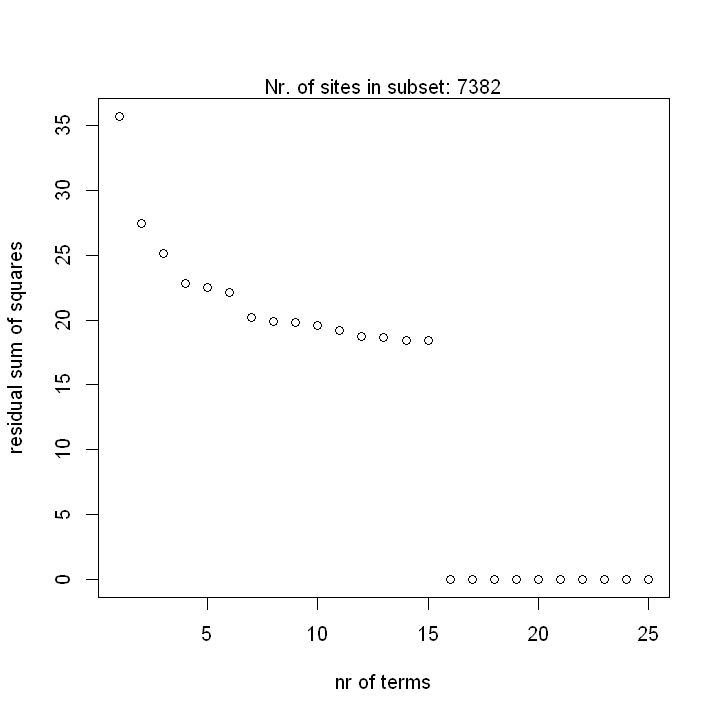

In [9]:
ppr_out = ppr(site_env_vars_scld, site_RSpca_vars, nterms=1, max.terms=25, sm.method='supsmu', bass=2)
plot(ppr_out$gofn, ylab="residual sum of squares", xlab="nr of terms")
mtext(paste("Nr. of sites in subset:",n_sites))

This curve usually typically exhibits a kind of kink (L-shaped curve) around some value, above which the sum of squares does not decrease much. This effect here seems to be more gradual, likely due to the amount of data points available (large number of sites). We can also see that the curve drops to zero from $k = 16$; this does not mean a perfect fit, but is more likely to results from numerical / computational issues.

For illustration purpose, we will select the number of ridge terms $K$ to be 12. Fitting the PPR model to the HCAS data can then be achieved as follows:

In [10]:
ppr_out = ppr(site_env_vars_scld, site_RSpca_vars, nterms=12, sm.method='supsmu', bass=2)

### Term loadings

For each term $k$, we can plot the term loadings for the ENV variables, i.e. the coefficients in the vector $\boldsymbol{\beta}_k$ used in the linear combinations of the ENV variables. For instance, for $k=1$, we have the following term loadings:

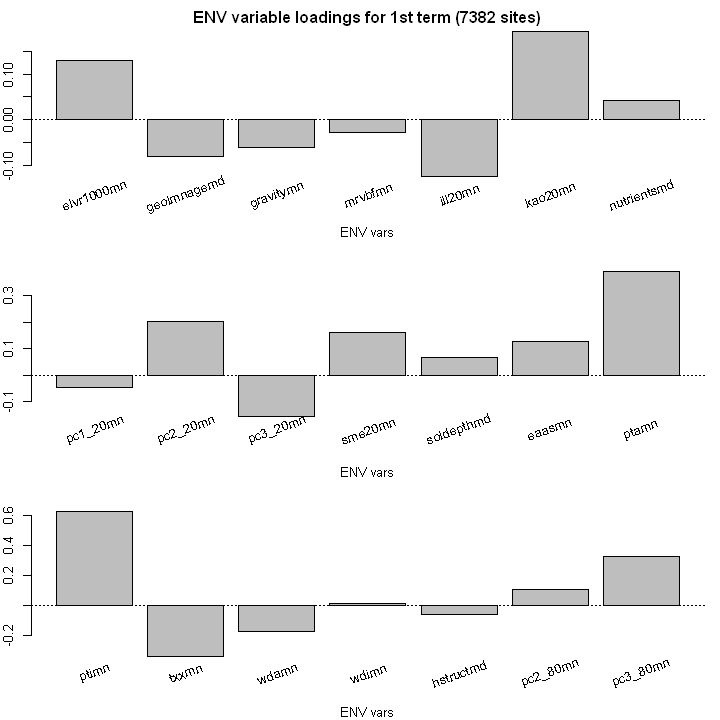

In [11]:
layout(matrix(1:3,ncol=1)); par(mar=c(4,2,2,1))

tmp = ppr_out$alpha[1:7,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars", 
            main=paste("ENV variable loadings for 1st term (",n_sites," sites)",sep=''))
abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[1:7], xpd=TRUE, srt=20)

tmp = ppr_out$alpha[8:14,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[8:14], xpd=TRUE, srt=20)

tmp = ppr_out$alpha[15:ppr_out$p,1]
x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[15:ppr_out$p], xpd=TRUE, srt=20)

These term loadings can be generated for each term $k=1...K$ and saved to file:

In [12]:
pdf('./HCAS_PPR_term_loadings.pdf')
layout(matrix(1:3,ncol=1))
for ( ii in 1:ppr_out$mu ) {
    tmp = ppr_out$alpha[1:7,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars", 
                main=paste("ENV variable loadings for term ",ii," (",n_sites," sites)",sep=''))
    abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[1:7], xpd=TRUE, srt=20)
    tmp = ppr_out$alpha[8:14,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
    abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[8:14], xpd=TRUE, srt=20)
    tmp = ppr_out$alpha[15:ppr_out$p,ii]
    x = barplot(tmp, ylab="", xaxt="n", xlab="ENV vars")
    abline(h=0,lty=3); text(cex=1, x=x, y=1.3*min(tmp), ppr_out$xnames[15:ppr_out$p], xpd=TRUE, srt=20)
}
tmp = dev.off()

These results appear to show that all ENV variables are involved with a significant term loading in at least one linear combination, indicating that all ENV variables are seemingly relevant to the model.

### Ridge functions

The next step is to look at the shape of the ridge functions $g_k(\cdot)$:

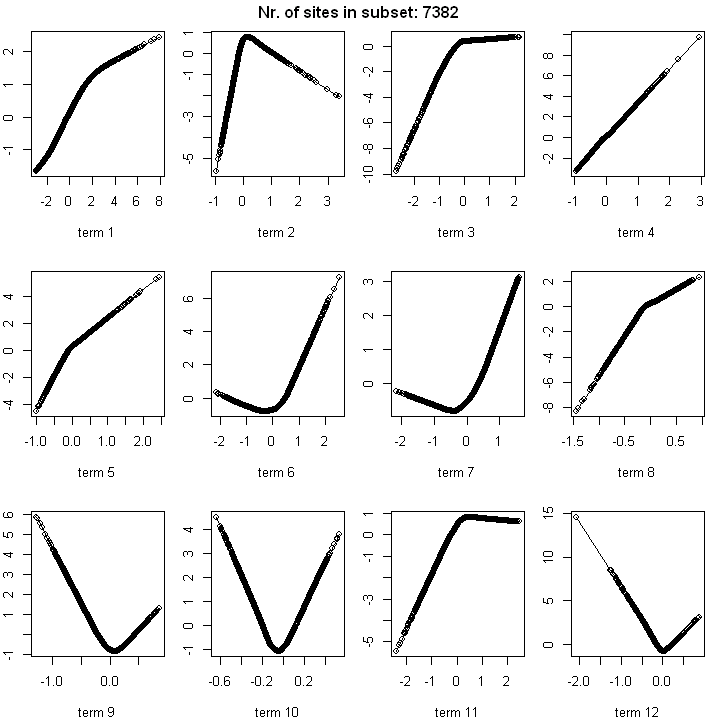

In [13]:
layout( matrix(1:12,nrow=3,byrow=T) )
par(mar=c(4,2,2,1))
plot(ppr_out)
title(paste("Nr. of sites in subset:",n_sites), outer = TRUE, line = -1.1)

Each of these plots represent the nonlinear transformation performed on the linear combination terms $\boldsymbol{\beta}_k^T \mathbf{x}$. THey can be used to check for evidence of over-fitting, in which case the `bass` parameter (which determines how smooth these functions are) can be fine-tuned.

Note that one drawback of the PPR approach is that its results are not readily interpretable. The ridge function are applied to _linear combinations_ of the ENV variables, and it is thus virtually impossible to derive a clear physical understanding of what sort of transformation the ridge functions apply to each of the ENV variables.

### Actual vs. fitted values

The PPR method has basically determined the transformations to apply to the ENV variables so that the resulting (transformed) ENV variables best correlate with the RS variables. We can thus check the relationship between these PPR-transformed ENV variables and the RS PCA variables:

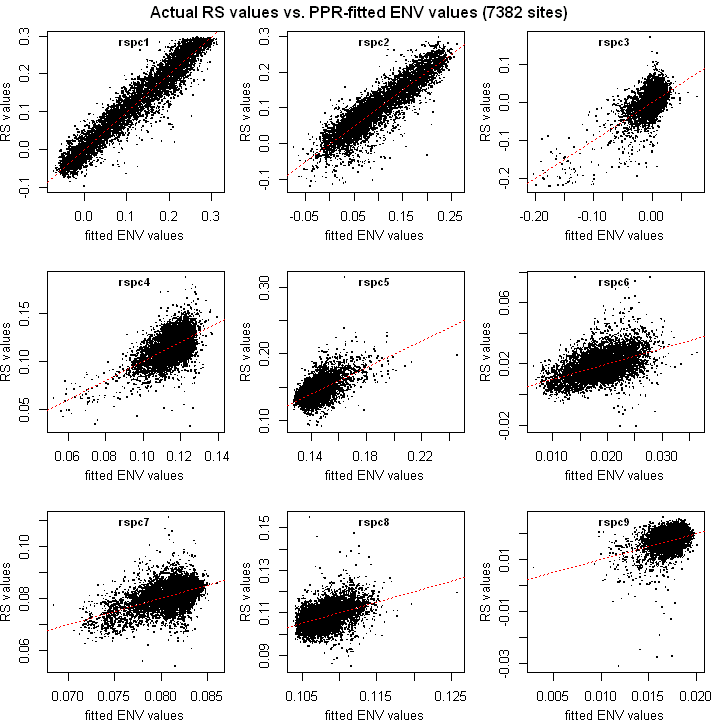

In [14]:
layout( matrix(1:9,nrow=3,byrow=T) )
par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    plot( ppr_out$fitted.values[,ii], site_RSpca_vars[,ii], ylab="", pch='.', cex=2, xlab="", main='')
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="RS values", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(0,1,lty=3,col='red')
}
title(paste("Actual RS values vs. PPR-fitted ENV values (",n_sites," sites)",sep=''), outer=TRUE, line=-1.1)

We can see that a good correlation results from PPR for most of the RS and fitted ENV variables. In contrast to GDM, the PPR model thus provides a relationship between the RS and ENV variables directly, which can subsequently be used to enable further improvements of the HCAS approach, e.g. by relating the change directions in both ENV and RS spaces (degradation pathways).

As a standard regression diagnostics, the residuals can also be investigated  to check for outliers and/or for any significant bias around the line at 0 (which would point to a poor model fit):

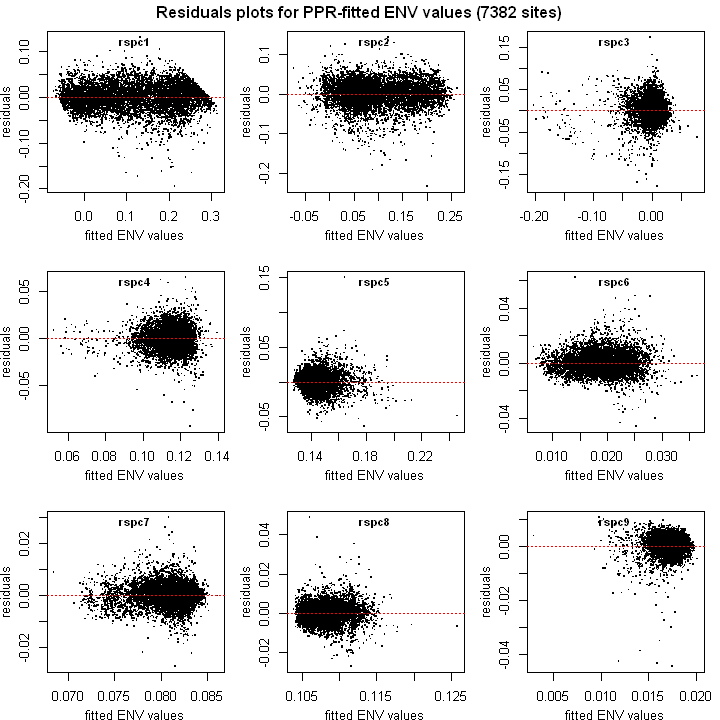

In [15]:
layout( matrix(1:9,nrow=3,byrow=T) )
par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    plot( ppr_out$fitted.values[,ii], ppr_out$residuals[,ii], ylab="", pch='.', cex=2, xlab="", main='')
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="residuals", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(h=0,lty=3,col='red')
}
title(paste("Residuals plots for PPR-fitted ENV values (",n_sites," sites)",sep=''), outer=TRUE, line=-1.1)

### RS distance vs. (transformed) ENV distance

As mentioned in the _'HCAS 3a(1) Methods Document'_, a crucial aspect of the current GDM approach is that it provides a direct correlation between distances in the transformed ENV and the RS spaces. This subsequently allows the prediction of RS distance (based on the known ENV distance) for a test site of interest whose condition has to be inferred.

It is thus important to also check the correlation among RS and ENV distances when using the PPR-fitted ENV variables. The RS distances (for each pair used in HCAS v1.0) have already been calculated offline for all pairs and saved to file. They can be loaded here as follows:

In [16]:
print( load(paste(base_path,'hcas_dist_RSpca9.Rdata',sep='')) )
length(rsm_dist_NonZeroPCA)

[1] "rsm_dist_NonZeroPCA"


[1] 986549

The PPR-based ENV distances can be calculated as follows. 

In [17]:
site_PPRenv_vars = ppr_out$fitted.values
PPRenv_dist = rep(NA,n_pairs)

for ( pp in 1:n_pairs ) {
    ind1 = which( subs_indx==pind_data_NonZeroPCA[p_subs_indx[pp],1] )
    ind2 = which( subs_indx==pind_data_NonZeroPCA[p_subs_indx[pp],2] )
    env1 = site_PPRenv_vars[ind1,] 
    env2 = site_PPRenv_vars[ind2,] 
    PPRenv_dist[pp] = sum(abs(env1-env2), na.rm=TRUE)    # Manhattan distance
}

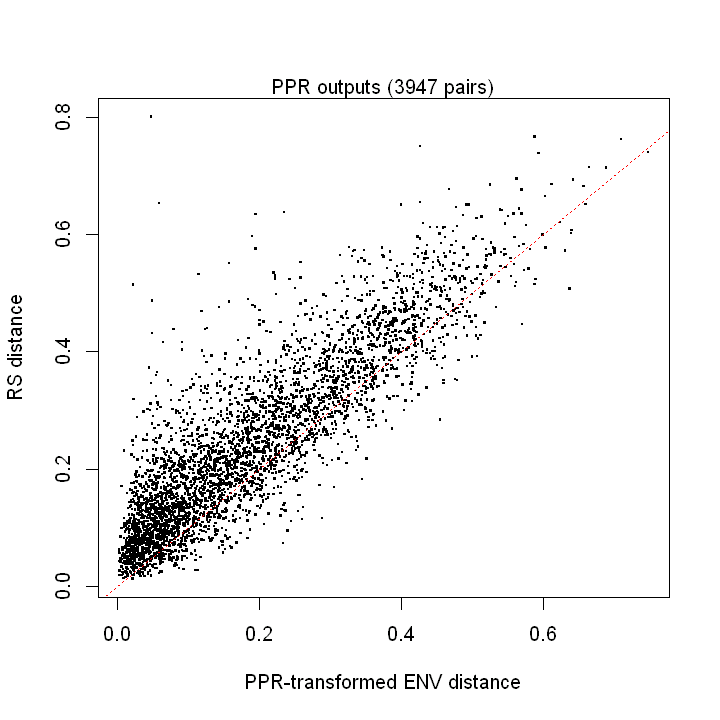

In [18]:
rsm_dist_NonZeroPCA = rsm_dist_NonZeroPCA[p_subs_indx]   # select desired pairs subset from pre-computed rsm_dist

plot(PPRenv_dist, rsm_dist_NonZeroPCA, pch='.', cex=2, xlab='', ylab='', main='')
title(xlab="PPR-transformed ENV distance", ylab="RS distance")
mtext(paste("PPR outputs (",n_pairs," pairs)",sep=''))
abline(0,1,lty=3,col='red')

## Results using all available sites / pairs

The above procedure has been applied offline to the entire HCAS dataset of approx. 425,000 sites (~1m pairs), using slightly different model parameters. The current results are presented below on the basis of results saved to file.

In [19]:
print( load(paste(base_path,'hcas_eda05_PPR_subs1_scaledENV_nTerms19_supsmu_bass1_dist.Rdata',sep='')) )
print( load(paste(base_path,'hcas_eda05_PPR_subs1_scaledENV_nTerms19_supsmu_bass1_ppr.Rdata',sep='')) )

[1] "PPRenv_dist" "rsm_dist"   
[1] "ppr_out"           "env_scaled_center" "env_scaled_scale" 


The second dataset also contains the scaling parameters used to scale the ENV data prior to the application of PPR.

First, let's display the relationships among the RS and PPR-transformed ENV variables (when all available sites / pairs are used).

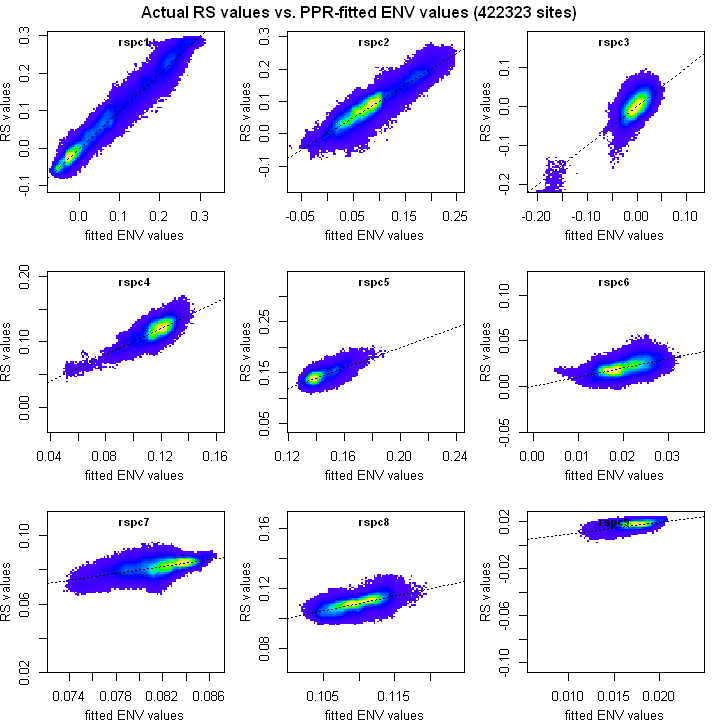

In [20]:
# We actually have to re-load the variable 'site_RSpca_vars' here to match the results saved to 
# file: 'ppr_out' was obtained using the full dataset of RS PCA (and ENV) variables.
load( paste(base_path,'HCAS_vars.Rdata',sep='') )
subs_indx = sort( unique( as.vector( pind_data_NonZeroPCA )))
site_RSpca_vars = site_RSpca_vars[subs_indx,1:9] / 4   # generates same dataset as used in the PPR fitting...
site_env_vars = site_env_vars[subs_indx,]              # generates same dataset as used in the PPR fitting...
n_sites = length(subs_indx)

layout( matrix(1:9,nrow=3,byrow=T) ); par(mar=c(3,3,2,1))
for ( ii in 1:ppr_out$q ) {
    tmp = hist2d(ppr_out$fitted.values[,ii], site_RSpca_vars[,ii], nbins=c(n_bins,n_bins), col=cmap)
    box()
    title(xlab="fitted ENV values", line=2.2)
    title(ylab="RS values", line=2.2)
    title(ppr_out$ynames[ii], line=-0.9, cex.main=0.8)
    abline(0,1,lty=3)
}
title(paste("Actual RS values vs. PPR-fitted ENV values (",n_sites," sites)",sep=''), outer=TRUE, line=-1.1)

And now the RS distances vs. PPR-based ENV distances (based on all available pairs).

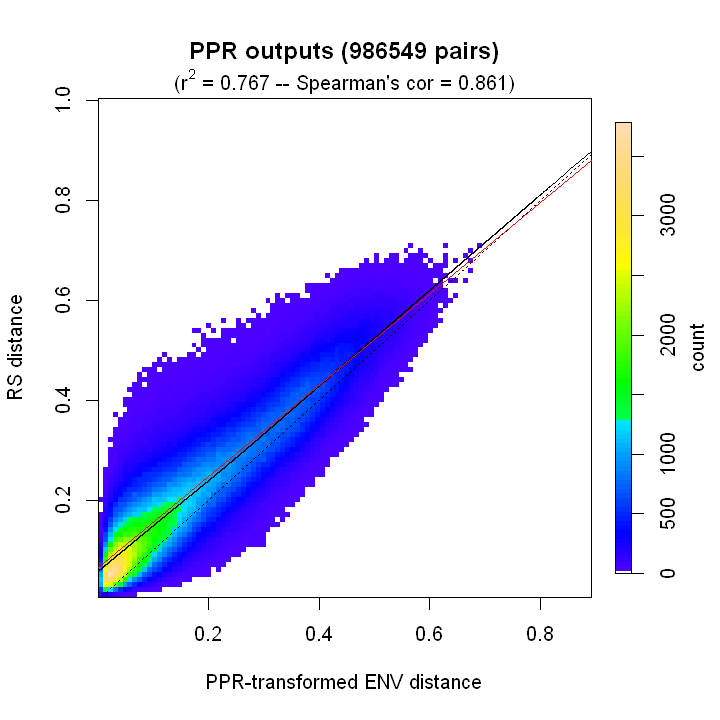

In [21]:
layout(matrix(c(1,2),nrow=1), widths=c(10,1.7)); par(mar=c(5.1,4.1,4.1,1))
tmp = hist2d(PPRenv_dist, rsm_dist, nbins=c(n_bins,n_bins), col=cmap); box()
title( xlab="PPR-transformed ENV distance", ylab="RS distance", 
       main=paste("PPR outputs (",length(rsm_dist)," pairs)",sep='') )
abline(0,1,lty=3)
lines(lowess(PPRenv_dist, rsm_dist), col="black")
lm_out = lm(rsm_dist~PPRenv_dist)
abline(lm_out, col="red")

r2 = round(summary(lm_out)$r.squared,3)
cc = round(cor(rsm_dist,PPRenv_dist,method='spearman'),3)
title( main=bquote(paste('(',r^2,' = ',.(r2)," -- Spearman's cor = ",.(cc),')',sep='')), 
       line=0.75, font.main=1, cex.main=1 )

cbar(0, max(tmp$count,na.rm=T), color_pal=cmap, 'count')

As in the GDM results (see previous notebook), there here appears to be a bias in the relationship (albeit somewhat less pronounced and more systematic / constant compared to GDM). The exact cause of this bias should be investigated further, and bias-correction methods could be used to further improve the relationship.

## Using PPR for prediction

The model fitted by PPR can be used to predict the RS signal expected for a given test site. Let's first use some test ENV variables (e.g. using the first site's values):

In [22]:
test_env_vec = site_env_vars[1,]
test_env_vec[1:10]
test_env_vec[11:21]

,elvr1000mn,geolmnagemd,gravitymn,mrvbfmn,ill20mn,kao20mn,nutrientsmd,pc1_20mn,pc2_20mn,pc3_20mn
1,105.8544,17.02199,556.9212,3,0.2671681,0.5508563,1,0.1470244,0.1786444,1.761004


,sme20mn,soldepthmd,eaasmn,ptamn,ptimn,txxmn,wdamn,wdimn,hstructmd,pc2_80mn,pc3_80mn
1,0.2053831,1.29999,829.991,1213.848,3.273668,33.28135,-314.5902,-132.4414,0,0.80208,1.106816


Before predicting the PPR output, we have to scale and center the ENV values:

In [23]:
test_env_vec_scld = (test_env_vec - env_scaled_center) / env_scaled_scale
test_env_vec_scld[1:10]
test_env_vec_scld[11:21]

,elvr1000mn,geolmnagemd,gravitymn,mrvbfmn,ill20mn,kao20mn,nutrientsmd,pc1_20mn,pc2_20mn,pc3_20mn
1,0.1348193,-0.4654038,2.244822,-0.0105785,1.200049,0.5960928,-0.6425369,0.5773012,-1.914766,-1.192498


,sme20mn,soldepthmd,eaasmn,ptamn,ptimn,txxmn,wdamn,wdimn,hstructmd,pc2_80mn,pc3_80mn
1,-0.6662362,1.475215,1.300315,1.127893,-0.6304777,-0.03151726,0.7602336,0.6255421,-0.6057648,1.001506,1.823148


We can now predict the RS signal for this vector of (scaled) ENV variables using the `predict` function:

In [24]:
t( predict(ppr_out, test_env_vec_scld) )

rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9
0.15451659,0.05473000,-0.01607118,0.11719187,0.15143991,0.02132400,0.07982349,0.11438562,0.01549241


And finally let's ensure we get the same prediction result as the original PPR-fitted outputs (we used the same test ENV variables as the first site that was used to fit the PPR):

In [25]:
t( ppr_out$fitted.values[1,] )

rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9
0.15451659,0.05473000,-0.01607118,0.11719187,0.15143991,0.02132400,0.07982349,0.11438562,0.01549241


Looks like a pretty good match... :-)

And of course, we can predict at any point of interest in ENV space (e.g. as we would do when extrapolating to the whole of Australia):

In [26]:
# Example: some hand-picked values:
test_env_vec = t(as.data.frame( c(100,15,500,2,0.5,0.6,1.5,0.2,0.2,2,0.1,1.5,800,1000,4,30,-300,-100,0,1,1) ))
test_env_vec_scld = (test_env_vec - env_scaled_center) / env_scaled_scale
t( predict(ppr_out, test_env_vec_scld) )

rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9
0.03781781,0.21943967,0.16471103,0.11061139,0.14657156,0.02256508,0.07591738,0.11368506,0.01381176


In [27]:
# Example: median ENV values:
test_env_vec = t(as.data.frame( apply(site_env_vars,2,median) ))
test_env_vec_scld = (test_env_vec - env_scaled_center) / env_scaled_scale
t( predict(ppr_out, test_env_vec_scld) )

rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9
0.04853165,0.05014709,-0.01925650,0.12123518,0.13427694,0.02249449,0.08249704,0.10891992,0.01818117
